# Transformer with MNIST (or Fashion MNIST)

* `Attention is All You Need`, [arXiv:1706.03762](https://arxiv.org/abs/1706.03762)
  * Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## 1. Import Modules

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 2. Hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'transformer_mnist'
train_dir = os.path.join('train', model_name, 'exp')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 1
batch_size = 4
learning_rate = 1e-4

width, height = 14, 14
TEST = False


## 3. Load the MNIST dataset

(60000, 14, 14)


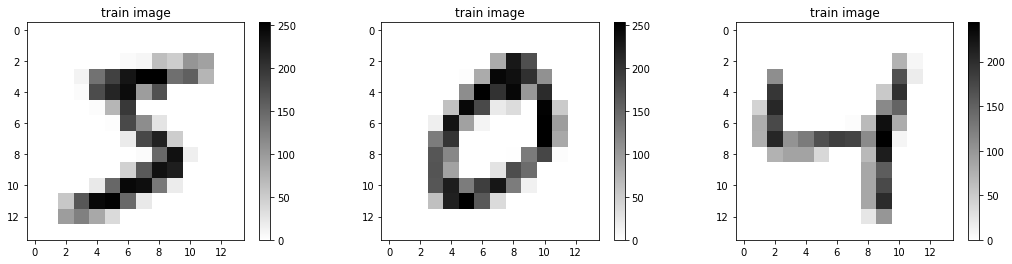

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')

train_images = tf.image.resize(train_images, size=[width, height])
train_images = tf.cast(train_images[:, :, :, 0], tf.int64)

print(train_images.shape)

plt.figure(figsize=[18, 4])
for i in range(3):
    
    plt.subplot(1, 3, i+1)
    plt.title('train image')
    plt.imshow(train_images[i], cmap='binary')
    plt.colorbar()

plt.show()
    

## 4. Create a dataset object

In [4]:
#tf.random.set_seed(117)
# for train
N = len(train_images)
        
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)


<BatchDataset shapes: (None, 14, 14), types: tf.int64>


## 5. Transformer Functions

In [5]:

# Reference : 
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention
# https://pytorch.org/docs/stable/_modules/torch/nn/functional.html
# https://github.com/openai/gpt-2/blob/master/src/model.py

class MultiheadAttention(tf.keras.Model):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(MultiheadAttention, self).__init__()
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        
        self.q_proj = layers.Dense(embed_dim)
        self.k_proj = layers.Dense(embed_dim)
        self.v_proj = layers.Dense(embed_dim)
        
        self.out_proj = layers.Dense(embed_dim)
        
    def call(self, query, key, value, attn_mask=None):
        
        # query : [batch, tgt_len, embed_dim]
        # key   : [batch, src_len, embed_dim]
        # value : [batch, src_len, embed_dim]
        
        batch, tgt_len, _ = query.shape
        _, src_len, _ = key.shape
        
        '''
        Query, Key, Value Projection
        '''
        # [batch, tgt_len, embed_dim]
        q = self.q_proj(query)
        # [batch, tgt_len, embed_dim]
        k = self.k_proj(key)
        # [batch, tgt_len, embed_dim]
        v = self.v_proj(value)
        
        '''
        Reshape for Multi-Head Attention
        '''
        # [batch, tgt_len, num_heads, head_dim]
        q = tf.reshape(q, [batch, tgt_len, self.num_heads, self.head_dim])
        # [batch, num_heads, tgt_len, head_dim]
        q = tf.transpose(q, [0, 2, 1, 3])
        
        # [batch, src_len, num_heads, head_dim]
        k = tf.reshape(k, [batch, src_len, self.num_heads, self.head_dim])
        # [batch, num_heads, src_len, head_dim]
        k = tf.transpose(k, [0, 2, 1, 3])
        
        # [batch, src_len, num_heads, head_dim]
        v = tf.reshape(v, [batch, src_len, self.num_heads, self.head_dim])
        # [batch, num_heads, src_len, head_dim]
        v = tf.transpose(v, [0, 2, 1, 3])
        
        
        '''
        w : Attention Output Weights
        '''
        # [batch, num_heads, tgt_len, src_len]
        w = tf.matmul(q, k, transpose_b=True)
        # scaling by square-root of head_dim
        w = w / np.sqrt(self.head_dim)
        
        if attn_mask is not None:
            w = w + attn_mask * -1e9
            
        # [batch, num_heads, tgt_len, src_len] 
        w = tf.nn.softmax(w, axis=-1)
        
        '''
        a : Attention Output
        '''
        # [batch, num_heads, tgt_len, head_dim]
        a = tf.matmul(w, v)
        # [batch, tgt_len, num_heads, head_dim]
        a = tf.transpose(a, [0, 2, 1, 3])
        # [batch, tgt_len, embed_dim]
        a = tf.reshape(a, [batch, tgt_len, self.embed_dim])
        
        out = self.out_proj(a)
        
        return out, tf.reduce_mean(w, axis=1)



In [6]:
class Feedforward(tf.keras.Model):
    def __init__(self, d_model, dim_feedforward, dropout, activation=tf.nn.relu):
        super(Feedforward, self).__init__()
        
        self.linear1 = layers.Dense(dim_feedforward, activation=activation)
        self.dropout = layers.Dropout(dropout)
        self.linear2 = layers.Dense(d_model)
        
    def call(self, x):
        x = self.linear1(x)
        x = self.dropout(x, training=True)
        x = self.linear2(x)
        
        return x


In [7]:
# Reference : https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerEncoderLayer
class TransformerEncoderLayer(tf.keras.Model):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=tf.nn.relu):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attn = MultiheadAttention(d_model, nhead, dropout)
        self.feed_forward = Feedforward(d_model, dim_feedforward, dropout, activation)
        
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

        
    def call(self, src, src_mask=None):
        # src : [batch, length, d_model]
        
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2, training=True)
        src = self.norm1(src)
        
        src2 = self.feed_forward(src)
        src = src + self.dropout2(src2, training=True)
        src = self.norm2(src)
        
        return src
    
# Reference : 
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerEncoder
class TransformerEncoder(tf.keras.Model):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, num_layers):
        super(TransformerEncoder, self).__init__()
        
        self.encoder_layers = [TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation) \
                       for _ in range(num_layers)]
        self.num_layers = num_layers
        
    def call(self, src, mask=None):
        # src : [batch, src_len, embed_dim]
        
        output = src
        for i in range(self.num_layers):
            output = self.encoder_layers[i](output, src_mask=mask)
            
        return output


## 6. Main Model

In [8]:
class Model(tf.keras.Model):
    def __init__(self, d_model=512, vocab_size=256):
        super(Model, self).__init__()
        
        self.global_step = tf.Variable(0, trainable=False)
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.transformer_encoder = TransformerEncoder(d_model=d_model, nhead=8, dim_feedforward=2048, dropout=0.1,
                                                     activation=tf.nn.relu, num_layers=6)
        self.logit_layer = layers.Dense(vocab_size)
        
        self.d_model = d_model
    
    @staticmethod
    def _get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    @staticmethod
    def _positional_encoding(position, d_model):
        angle_rads = Model._get_angles(np.arange(position)[:, np.newaxis],
                               np.arange(d_model)[np.newaxis, :],
                               d_model)

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    @staticmethod
    def _create_look_ahead_mask(size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

    def call(self, images):
        # images : [batch, src_length]
        
        _, src_length = images.shape
        
        # [batch, src_length, d_model]
        src = self.embedding(images) + self._positional_encoding(src_length, self.d_model)
        
        mask = self._create_look_ahead_mask(src_length)
        output = self.transformer_encoder(src, mask=mask)
        logit = self.logit_layer(output)
        
        return logit
    
    def inference(self, images):
        from tqdm.notebook import tqdm

        for i in tqdm(range(0, width*height)):
            logit = self.call(images)
            sample = tf.random.categorical(logit[:, i], num_samples=1)
            images = tf.concat([images[:, :i+1], sample, images[:, i+2:]], axis=1)
        
        return images[:, 1:]
        

## 7. Create a model object 

In [9]:
model = Model()
print(model)

### 2D-image to 1D-vector, 1D-vector to 2D-image

In [10]:
def image_to_vector(images):
    batch, height, width = images.shape
    vector = tf.reshape(images, [batch, height*width])
    return vector

def vector_to_image(vectors, height, width):
    batch, dim = vectors.shape
    images = tf.reshape(vectors, [batch, height, width])
    return images


### Create a unconditional image 

  0%|          | 0/196 [00:00<?, ?it/s]

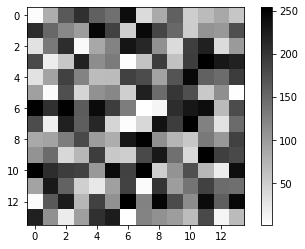

In [11]:
images = model.inference(tf.zeros([1, width*height], dtype=tf.int64))
pred = vector_to_image(images, width, height)
plt.imshow(pred[0], cmap='binary')
plt.colorbar()


## 8. Loss Function and Optimizer

In [12]:
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 9. Define a single train step

In [13]:
@tf.function
def train_step(model, optimizer, images):
    
    with tf.GradientTape() as tape:
           
        images_shifted = tf.concat([tf.zeros([images.shape[0], 1], dtype=tf.int64), images[:, :-1]], axis=1)
        logit = model(images_shifted)
        loss = cce(images, logit)
        
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    return logit, loss
        

## 10. Main Train Loop

Creating Images...


  0%|          | 0/196 [00:00<?, ?it/s]

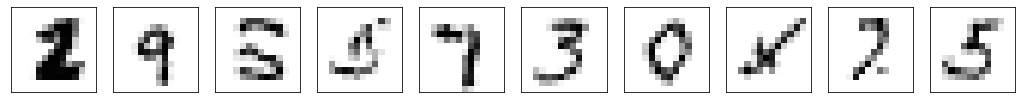

In [14]:

averaged_loss = None
for epoch in range(max_epochs):
    display.clear_output(wait=True)
    print('epoch :', epoch + 1)
    for i, images in enumerate(train_dataset):
        images = image_to_vector(images)
        
        logit, loss = train_step(model, optimizer, images)
        model.global_step.assign_add(1)
        global_step = model.global_step.numpy()
        averaged_loss = loss.numpy() if averaged_loss is None else averaged_loss*0.9 + loss.numpy()*0.1
        
        if global_step % 100 == 0:
            print('global step :', global_step, 'cross-entropy loss :', averaged_loss)
            
        if global_step % 1000 == 0:
            display.clear_output(wait=True)
            print('Creating Images...')
            images = model.inference(tf.zeros([10, width*height], dtype=tf.int64))
            pred = vector_to_image(images, width, height)

            plt.figure(figsize=[18, 3])
            for j in range(10):
                plt.subplot(1, 10, j+1)
                plt.imshow(pred[j], cmap='binary')
                plt.xticks([])
                plt.yticks([])
            plt.show()     
